In [1]:
MAX_TIME = 10
INIT_SIZE = 5

In [2]:
import pickle
import socket
from datetime import datetime
from dateutil.tz import tzlocal
start_time = datetime.now(tzlocal())
HOSTNAME = socket.gethostname().split(".")[0]
experiment_name = '13-torch' + "_" + HOSTNAME + "_" + str(MAX_TIME) + "min_" + str(INIT_SIZE) + "init_" + str(start_time).split(".", 1)[0].replace(' ', '_')
experiment_name = experiment_name.replace(':', '-')
experiment_name

'13-torch_p040025_10min_5init_2023-05-06_09-44-38'

# Chapter 13: Sequential Parameter Optimization
## Hyperparameter Tuning: pytorch cross validation  with fashionMNIST Data

* This notebook exemplifies hyperparameter tuning with SPOT (spotPython).
* The hyperparameter software SPOT was developed in R (statistical programming language), see Open Access book "Hyperparameter Tuning for Machine and Deep Learning with R - A Practical Guide", available here: [https://link.springer.com/book/10.1007/978-981-19-5170-1](https://link.springer.com/book/10.1007/978-981-19-5170-1).


In [3]:
pip list | grep  "spot[RiverPython]"

spotPython                                0.0.50
spotRiver                                 0.0.92
Note: you may need to restart the kernel to use updated packages.


In [4]:
# import sys
# !{sys.executable} -m pip install --upgrade build
# !{sys.executable} -m pip install --upgrade --force-reinstall spotPython


In [5]:
import torch
from tabulate import tabulate
import copy
import warnings
import numbers
import json
import calendar
import math
import datetime as dt
import numpy as np
from math import inf
import pandas as pd

from scipy.optimize import differential_evolution

import matplotlib.pyplot as plt

from spotPython.spot import spot
from spotPython.hyperparameters.values import (
    add_core_model_to_fun_control,
    assign_values,
    convert_keys,
    get_bound_values,
    get_default_hyperparameters_for_core_model,
    get_default_values,
    get_dict_with_levels_and_types,
    get_values_from_dict,
    get_var_name,
    get_var_type,
    iterate_dict_values,
    modify_hyper_parameter_levels,
    modify_hyper_parameter_bounds,
    replace_levels_with_positions,
    return_conf_list_from_var_dict,
    get_one_core_model_from_X,
    transform_hyper_parameter_values,
    get_dict_with_levels_and_types,
    convert_keys,
    iterate_dict_values,
)

from spotPython.utils.convert import class_for_name
from spotPython.utils.eda import (
    get_stars,
    gen_design_table)
from spotPython.utils.transform import transform_hyper_parameter_values

from spotPython.data.torch_hyper_dict import TorchHyperDict
from spotPython.fun.hypertorch import HyperTorch
from spotPython.utils.convert import get_Xy_from_df
from spotPython.plot.validation import plot_cv_predictions, plot_roc, plot_confusion_matrix
from spotPython.torch.netcvfashionMNIST import Net_CV_fashionMNIST

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from functools import partial
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
import torchvision
import torchvision.transforms as transforms

warnings.filterwarnings("ignore")

In [6]:
print(torch.__version__)
# Check that MPS is available
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    mps_device = torch.device("mps")
    print("MPS device: ", mps_device)

2.0.0
MPS device:  mps


## 0. Initialization of the Empty `fun_control` Dictionary

In [7]:
fun_control = {}

## 1. Load fashionMNIST Data

In [8]:
def load_data(data_dir="./data"):
    # Download training data from open datasets.
    training_data = datasets.FashionMNIST(
        root=data_dir,
        train=True,
        download=True,
        transform=ToTensor(),
    )
    # Download test data from open datasets.
    test_data = datasets.FashionMNIST(
        root=data_dir,
        train=False,
        download=True,
        transform=ToTensor(),
    )
    return training_data, test_data

In [9]:
train, test = load_data()

In [10]:
train.data.shape, test.data.shape
train

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [11]:
n_samples = len(train)
# add the dataset to the fun_control
fun_control.update({"data": None, # dataset,
               "train": train,
               "test": test,
               "n_samples": n_samples,
               "target_column": None})


## 2. Specification of the Preprocessing Model

In [12]:
# categorical_columns = []
# one_hot_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
# prep_model = ColumnTransformer(
#         transformers=[
#             ("categorical", one_hot_encoder, categorical_columns),
#         ],
#         remainder=StandardScaler(),
#     )
prep_model = None
fun_control.update({"prep_model": prep_model})

## 3. Select `algorithm` and `core_model_hyper_dict`

In [13]:
# core_model  = RidgeCV
core_model = Net_CV_fashionMNIST
fun_control = add_core_model_to_fun_control(core_model=core_model,
                              fun_control=fun_control,
                              hyper_dict=TorchHyperDict,
                              filename=None)

## 4. Modify `hyper_dict` Hyperparameters for the Selected Algorithm aka `core_model`

### Modify hyperparameter of type factor

In [14]:
# fun_control = modify_hyper_parameter_levels(fun_control, "leaf_model", ["LinearRegression"])
# fun_control["core_model_hyper_dict"]

### Modify hyperparameter of type numeric and integer (boolean)

In [15]:
# fun_control = modify_hyper_parameter_bounds(fun_control, "delta", bounds=[1e-10, 1e-6])
# fun_control = modify_hyper_parameter_bounds(fun_control, "min_samples_split", bounds=[3, 20])
#fun_control = modify_hyper_parameter_bounds(fun_control, "merit_preprune", bounds=[0, 0])
# fun_control["core_model_hyper_dict"]
fun_control = modify_hyper_parameter_bounds(fun_control, "k_folds", bounds=[2, 2])

## 5. Selection of the Objective (Loss) Function

There are two metrics:

    1. `metric` is used for the river based evaluation via `eval_oml_iter_progressive`.
    2. `metric_sklearn` is used for the sklearn based evaluation.

In [16]:
fun = HyperTorch(seed=123, log_level=50).fun_torch
weights = -1.0
horizon = 7*24
oml_grace_period = 2
step = 100
weight_coeff = 1.0

fun_control.update({
               "data_dir": None,
               "checkpoint_dir": None,
               "horizon": horizon,
               "oml_grace_period": oml_grace_period,
               "weights": weights,
               "step": step,
               "log_level": 50,
               "weight_coeff": weight_coeff,
               "metric": None,
               "metric_sklearn": None
               })

## 6. Calling the SPOT Function

### Prepare the SPOT Parameters

* Get types and variable names as well as lower and upper bounds for the hyperparameters.

In [17]:
var_type = get_var_type(fun_control)
var_name = get_var_name(fun_control)
fun_control.update({"var_type": var_type,
                    "var_name": var_name})

lower = get_bound_values(fun_control, "lower")
upper = get_bound_values(fun_control, "upper")

In [18]:
print(gen_design_table(fun_control))

| name       | type   |   default |   lower |   upper | transform             |
|------------|--------|-----------|---------|---------|-----------------------|
| l1         | int    |     5     |  2      |     9   | transform_power_2_int |
| l2         | int    |     5     |  2      |     9   | transform_power_2_int |
| lr         | float  |     0.001 |  0.0001 |     0.1 | None                  |
| batch_size | int    |     4     |  1      |     4   | transform_power_2_int |
| epochs     | int    |     3     |  1      |     4   | transform_power_2_int |
| k_folds    | int    |     2     |  2      |     2   | None                  |


### Run the `Spot` Optimizer

* Run SPOT for approx. x mins (`max_time`).
* Note: the run takes longer, because the evaluation time of initial design (here: `initi_size`, 20 points) is not considered.

In [19]:
spot_torch = spot.Spot(fun=fun,
                   lower = lower,
                   upper = upper,
                   fun_evals = inf,
                   fun_repeats = 1,
                   max_time = MAX_TIME,
                   noise = False,
                   tolerance_x = np.sqrt(np.spacing(1)),
                   var_type = var_type,
                   var_name = var_name,
                   infill_criterion = "y",
                   n_points = 1,
                   seed=123,
                   log_level = 50,
                   show_models= False,
                   show_progress= True,
                   fun_control = fun_control,
                   design_control={"init_size": INIT_SIZE,
                                   "repeats": 1},
                   surrogate_control={"noise": True,
                                      "cod_type": "norm",
                                      "min_theta": -4,
                                      "max_theta": 3,
                                      "n_theta": len(var_name),
                                      "model_optimizer": differential_evolution,
                                      "model_fun_evals": 10_000,
                                      "log_level": 50
                                      })
spot_torch.run()

spotPython tuning: [##########] 100.00% Done...


### 4 Results

In [20]:
SAVE = True
LOAD = False

if SAVE:
    result_file_name = "res_" + experiment_name + ".pkl"
    with open(result_file_name, 'wb') as f:
        pickle.dump(spot_torch, f)

if LOAD:
    result_file_name = "res_ch10-friedman-hpt-0_maans03_60min_20init_1K_2023-04-14_10-11-19.pkl"
    with open(result_file_name, 'rb') as f:
        spot_torch =  pickle.load(f)

* Show the Progress of the hyperparameter tuning:

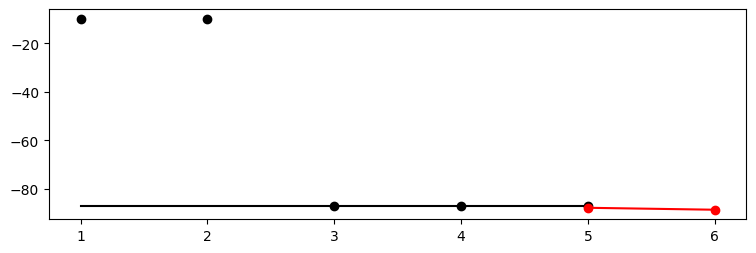

In [21]:
spot_torch.plot_progress(log_y=False, filename="../Figures.d/" + experiment_name+"_progress.pdf")



* Print the Results

In [22]:
res = spot_torch.print_results(print_screen=False)
print(tabulate(
   res,
   headers=["Parameter", "Value"],
   numalign="right",
   tablefmt="github")
)

| Parameter   |   Value |
|-------------|---------|
| l1          |       8 |
| l2          |       7 |
| lr          |  0.0001 |
| batch_size  |       3 |
| epochs      |       3 |
| k_folds     |       2 |


## Show variable importance

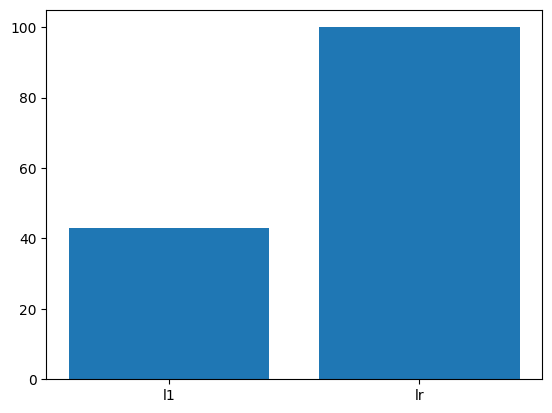

In [23]:
spot_torch.plot_importance(threshold=0.025, filename="../Figures.d/" + experiment_name+"_importance.pdf")

In [24]:
print(gen_design_table(fun_control=fun_control, spot=spot_torch))

| name       | type   |   default |   lower |   upper |   tuned | transform             |   importance | stars   |
|------------|--------|-----------|---------|---------|---------|-----------------------|--------------|---------|
| l1         | int    |       5.0 |     2.0 |     9.0 |     8.0 | transform_power_2_int |        43.07 | *       |
| l2         | int    |       5.0 |     2.0 |     9.0 |     7.0 | transform_power_2_int |         0.01 |         |
| lr         | float  |     0.001 |  0.0001 |     0.1 |  0.0001 | None                  |       100.00 | ***     |
| batch_size | int    |       4.0 |     1.0 |     4.0 |     3.0 | transform_power_2_int |         0.01 |         |
| epochs     | int    |       3.0 |     1.0 |     4.0 |     3.0 | transform_power_2_int |         0.01 |         |
| k_folds    | int    |       2.0 |     2.0 |     2.0 |     2.0 | None                  |              |         |


## Get Default Hyperparameters

In [25]:
values_default = get_default_hyperparameters_for_core_model(fun_control=fun_control)
values_default

{'l1': 32, 'l2': 32, 'lr': 0.001, 'batch_size': 16, 'epochs': 8, 'k_folds': 2}

In [26]:
model_default = fun_control["core_model"](**values_default)
model_default


Net_CV_fashionMNIST(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=10, bias=True)
  )
)

## Get SPOT Results

In [27]:
X = spot_torch.to_all_dim(spot_torch.min_X.reshape(1,-1))
print(X)


[[8.e+00 7.e+00 1.e-04 3.e+00 3.e+00 2.e+00]]


In [28]:
model_spot = get_one_core_model_from_X(X, fun_control)
model_spot

Net_CV_fashionMNIST(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)

## Test Set Accuracy

In [29]:
testset = fun_control["test"]
testset.data.shape

torch.Size([10000, 28, 28])

In [30]:
model_default.evaluate_cv(dataset = testset)

(83.16, nan)

In [31]:
model_spot.evaluate_cv(dataset = testset)

(83.42999999999999, nan)

In [32]:
min(spot_torch.y), max(spot_torch.y)

(-88.6, -9.816666666666666)

## Detailed Hyperparameter Plots

* For productive use, you might want to select:
  * `min_z=min(spot_torch.y)` and
  * `max_z = max(spot_torch.y)`
* These settings are not so colorful as visualizations that use `None` for the ranges, but give better insights.

l1:  43.074596736434636
lr:  100.0


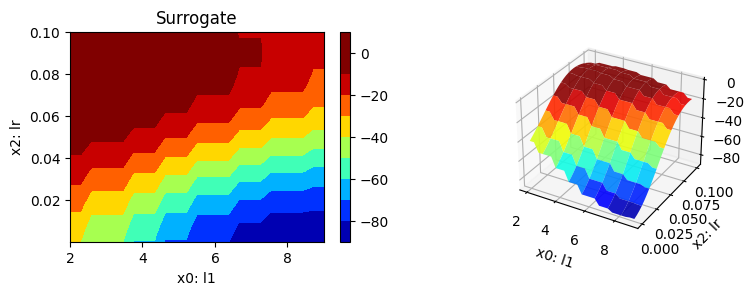

In [33]:
threshold = 0.025
impo = spot_torch.print_importance(threshold=threshold, print_screen=True)
var_plots = [i for i, x in enumerate(impo) if x[1] > threshold]
min_z = min(spot_torch.y)
max_z = max(spot_torch.y)
n = spot_torch.k
for i in var_plots:
    for j in var_plots:
        if j > i:
            filename = "../Figures.d/" + experiment_name+"_contour_"+str(i)+"_"+str(j)+".pdf"
            spot_torch.plot_contour(i=i, j=j, min_z=min_z, max_z = max_z, filename=filename)

## Parallel Coordinates Plot

In [34]:
spot_torch.parallel_plot()

## Plot all Combinations of Hyperparameters

* Warning: this may take a while.

In [35]:
PLOT_ALL = False
if PLOT_ALL:
    n = spot_torch.k
    for i in range(n-1):
        for j in range(i+1, n):
            spot_torch.plot_contour(i=i, j=j, min_z=min_z, max_z = max_z)

In [37]:
# def evaluate_cv(self, dataset, shuffle=False):
#     criterion = nn.CrossEntropyLoss()
#     optimizer = optim.SGD(self.parameters(), lr=self.lr, momentum=0.9)
#     kfold = KFold(n_splits=self.k_folds, shuffle=shuffle)
#     for fold, (train_ids, val_ids) in enumerate(kfold.split(dataset)):
#         train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
#         val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)
#         trainloader = torch.utils.data.DataLoader(dataset, batch_size=self.batch_size, sampler=train_subsampler)
#         valloader = torch.utils.data.DataLoader(dataset, batch_size=self.batch_size, sampler=val_subsampler)
#         self.reset_weights()
#         for epoch in range(self.epochs):
#             for i, data in enumerate(trainloader, 0):
#                 inputs, labels = data
#                 inputs, labels = inputs.to(device), labels.to(device)
#                 optimizer.zero_grad()
#                 outputs = self(inputs)
#                 loss = criterion(outputs, labels)
#                 loss.backward()
#                 optimizer.step()
#         val_loss = 0.0
#         val_steps = 0
#         total = 0
#         correct = 0
#         for i, data in enumerate(valloader, 0):
#             with torch.no_grad():
#                 inputs, labels = data
#                 inputs, labels = inputs.to(device), labels.to(device)
#                 outputs = self(inputs)
#                 _, predicted = torch.max(outputs.data, 1)
#                 total += labels.size(0)
#                 correct += (predicted == labels).sum().item()
#                 loss = criterion(outputs, labels)
#                 val_loss += loss.cpu().numpy()
#                 val_steps += 1
#         self.results[fold] = 100.0 * (correct / total)
#     return sum(self.results.values()) / len(self.results.values())

In [38]:
# def evaluate_cv(self, dataset, shuffle=False):
#     criterion = nn.CrossEntropyLoss()
#     optimizer = optim.Adam(self.parameters(), lr=self.lr)
#     kfold = KFold(n_splits=self.k_folds, shuffle=shuffle)
#     for fold, (train_ids, val_ids) in enumerate(kfold.split(dataset)):
#         train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
#         val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)
#         trainloader = torch.utils.data.DataLoader(dataset, batch_size=self.batch_size, sampler=train_subsampler, num_workers=4)
#         valloader = torch.utils.data.DataLoader(dataset, batch_size=self.batch_size, sampler=val_subsampler, num_workers=4)
#         self.reset_weights()
#         for epoch in range(self.epochs):
#             for i, data in enumerate(trainloader, 0):
#                 inputs, labels = data
#                 inputs, labels = inputs.to(device), labels.to(device)
#                 optimizer.zero_grad()
#                 outputs = self(inputs)
#                 loss = criterion(outputs, labels)
#                 loss.backward()
#                 optimizer.step()
#         val_loss = 0.0
#         val_steps = 0
#         total = 0
#         correct = 0
#         for i, data in enumerate(valloader, 0):
#             with torch.no_grad():
#                 inputs, labels = data
#                 inputs, labels = inputs.to(device), labels.to(device)
#                 outputs = self(inputs)
#                 _, predicted = torch.max(outputs.data, 1)
#                 total += labels.size(0)
#                 correct += (predicted == labels).sum().item()
#                 loss = criterion(outputs, labels)
#                 val_loss += loss.cpu().numpy()
#                 val_steps += 1
#         self.results[fold] = 100.0 * (correct / total)
#     return sum(self.results.values()) / len(self.results.values())

In [39]:
# def evaluate_cv(self, dataset, shuffle=False):
#     criterion = nn.CrossEntropyLoss()
#     optimizer = optim.Adam(self.parameters(), lr=self.lr)
#     kfold = KFold(n_splits=self.k_folds, shuffle=shuffle)
#     for fold, (train_ids, val_ids) in enumerate(kfold.split(dataset)):
#         train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
#         val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)
#         trainloader = torch.utils.data.DataLoader(dataset, batch_size=self.batch_size, sampler=train_subsampler, num_workers=4, pin_memory=True)
#         valloader = torch.utils.data.DataLoader(dataset, batch_size=self.batch_size, sampler=val_subsampler, num_workers=4, pin_memory=True)
#         self.reset_weights()
#         for epoch in range(self.epochs):
#             for i, data in enumerate(trainloader, 0):
#                 inputs, labels = data
#                 inputs, labels = inputs.to(device), labels.to(device)
#                 optimizer.zero_grad()
#                 outputs = self(inputs)
#                 loss = criterion(outputs, labels)
#                 loss.backward()
#                 optimizer.step()
#         val_loss = 0.0
#         val_steps = 0
#         total = 0
#         correct = 0
#         for i, data in enumerate(valloader, 0):
#             with torch.no_grad():
#                 inputs, labels = data
#                 inputs, labels = inputs.to(device), labels.to(device)
#                 outputs = self(inputs)
#                 _, predicted = torch.max(outputs.data, 1)
#                 total += labels.size(0)
#                 correct += (predicted == labels).sum().item()
#                 loss = criterion(outputs, labels)
#                 val_loss += loss.cpu().numpy()
#                 val_steps += 1
#         self.results[fold] = 100.0 * (correct / total)
#     return sum(self.results.values()) / len(self.results.values())

In [40]:
# def train_fold(self, trainloader, criterion, optimizer):
#     for epoch in range(self.epochs):
#         for i, data in enumerate(trainloader, 0):
#             inputs, labels = data
#             inputs, labels = inputs.to(device), labels.to(device)
#             optimizer.zero_grad()
#             outputs = self(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()

# def validate_fold(self, valloader, criterion):
#     val_loss = 0.0
#     val_steps = 0
#     total = 0
#     correct = 0
#     for i, data in enumerate(valloader, 0):
#         with torch.no_grad():
#             inputs, labels = data
#             inputs, labels = inputs.to(device), labels.to(device)
#             outputs = self(inputs)
#             _, predicted = torch.max(outputs.data, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()
#             loss = criterion(outputs, labels)
#             val_loss += loss.cpu().numpy()
#             val_steps += 1
#     return 100.0 * (correct / total)

# def evaluate_cv(self, dataset, shuffle=False):
#     criterion = nn.CrossEntropyLoss()
#     optimizer = optim.Adam(self.parameters(), lr=self.lr)
#     kfold = KFold(n_splits=self.k_folds, shuffle=shuffle)
#     for fold, (train_ids, val_ids) in enumerate(kfold.split(dataset)):
#         train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
#         val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)
#         trainloader = torch.utils.data.DataLoader(dataset, batch_size=self.batch_size, sampler=train_subsampler, num_workers=4)
#         valloader = torch.utils.data.DataLoader(dataset, batch_size=self.batch_size, sampler=val_subsampler, num_workers=4)
#         self.reset_weights()
#         self.train_fold(trainloader, criterion, optimizer)
#         self.results[fold] = self.validate_fold(valloader, criterion)
#     return sum(self.results.values()) / len(self.results.values())

In [ ]:
def evaluate_hold_out(self, dataset):
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.parameters(), lr=self.lr)
        test_abs = int(len(dataset) * 0.6)
        train_subset, val_subset = random_split(dataset, [test_abs, len(dataset) - test_abs])
        trainloader = torch.utils.data.DataLoader(
            train_subset,
            batch_size=int(self.batch_size),
            shuffle=True,
            num_workers=8,
        )
        valloader = torch.utils.data.DataLoader(
            val_subset,
            batch_size=int(self.batch_size),
            shuffle=True,
            num_workers=8,
        )
        for epoch in range(self.epochs):
            for i, data in enumerate(trainloader, 0):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = self(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
            val_loss = 0.0
            val_steps = 0
            total = 0
            correct = 0
            pred_list = []
            for i, data in enumerate(valloader, 0):
                with torch.no_grad():
                    inputs, labels = data
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = self(inputs)
                    _, predicted = torch.max(outputs.data, 1)
                    pred_list.append(predicted)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    loss = criterion(outputs, labels)
                    val_loss += loss.cpu().numpy()
                    val_steps += 1
        return val_loss / val_steps